# Resources

# Intro

# Step 1: Install And Import Libraries

In [1]:
# Install libraries
!pip install yfinance prophet

After the package installation, we need to import libraries for this tutorial.

`numpy` and `pandas` are for data processing. `yfinance` is for pulling the data.

Prophet is for building the time series forecast. `.plot` is for model output visualization, and `.diagnostics` is for model performance evaluation.

`plotly` is imported to visualize the AAPL price trend.


In [2]:
# Data processing
import numpy as np
import pandas as pd

# Get time series data
import yfinance as yf

# Prophet model for time series forecast
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

# Visualization
import plotly.graph_objs as go

# Step 2: Get Dataset AAPL

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Download Dataset

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_project/Dataset/1980-2021/AAPL.csv')
# Reset index and have date as a column
data.reset_index(inplace=True)

# Change date to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Take a look at the data
data.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


In [5]:
# Declare a figure
fig = go.Figure()

# Candlestick chart
fig.add_trace(go.Candlestick(x=data.Date,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'],
                name = 'Data'))

In [6]:
# Keep only date and close price
df = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

# Rename date to ds and close price to y
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

# Take a look at the data
df.head()

,index,ds,y
0,0,1980-12-12,0.128348
1,1,1980-12-15,0.121652
2,2,1980-12-16,0.112723
3,3,1980-12-17,0.115513
4,4,1980-12-18,0.118862


In [7]:
# Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   10468 non-null  int64         
 1   ds      10468 non-null  datetime64[ns]
 2   y       10468 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 245.5 KB


# Step 3: Train Test Split

In [8]:
# Train test split
df_train = df[df['ds']<='2000-11-30']
df_test = df[df['ds']>'2000-11-30']

# Print the number of records and date range for training and testing dataset.
print('The training dataset has', len(df_train), 'records, ranging from', df_train['ds'].min(), 'to', df_train['ds'].max())
print('The testing dataset has', len(df_test), 'records, ranging from', df_test['ds'].min(), 'to', df_test['ds'].max())

The training dataset has 5048 records, ranging from 1980-12-12 00:00:00 to 2000-11-30 00:00:00
The testing dataset has 5420 records, ranging from 2000-12-01 00:00:00 to 2022-06-17 00:00:00


# Step 4: Train Time Series Model Using Prophet

In [9]:
# Create the prophet model with confidence internal of 95%
m = Prophet(interval_width=0.95, n_changepoints=7)

# Fit the model using the training dataset
m.fit(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl2zzi33h/hrfs9nmf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl2zzi33h/iki9qq9z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40650', 'data', 'file=/tmp/tmpl2zzi33h/hrfs9nmf.json', 'init=/tmp/tmpl2zzi33h/iki9qq9z.json', 'output', 'file=/tmp/tmpl2zzi33h/prophet_modelrie7b03k/prophet_model-20240724144549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:45:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:45:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# Step 5: Use Prophet Model To Make Prediction

In [10]:
# Create a future dataframe for prediction
future = m.make_future_dataframe(periods=31)

# Forecast the future dataframe values
forecast = m.predict(future)

# Check the forecasted values and upper/lower bound
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5074,2000-12-27,0.837881,0.654821,1.029155
5075,2000-12-28,0.839870,0.641335,1.037328
5076,2000-12-29,0.840717,0.639868,1.044538
5077,2000-12-30,0.864619,0.660265,1.082572
5078,2000-12-31,0.866091,0.666747,1.058392


The x-axis is the date in the forecast visualization, and the y axis is the close price. The black dots are the actual prices in the training dataset, and the red dots are the actual forecast prices. The blue line is the time series model prediction. The shaded area is the 95% prediction interval.

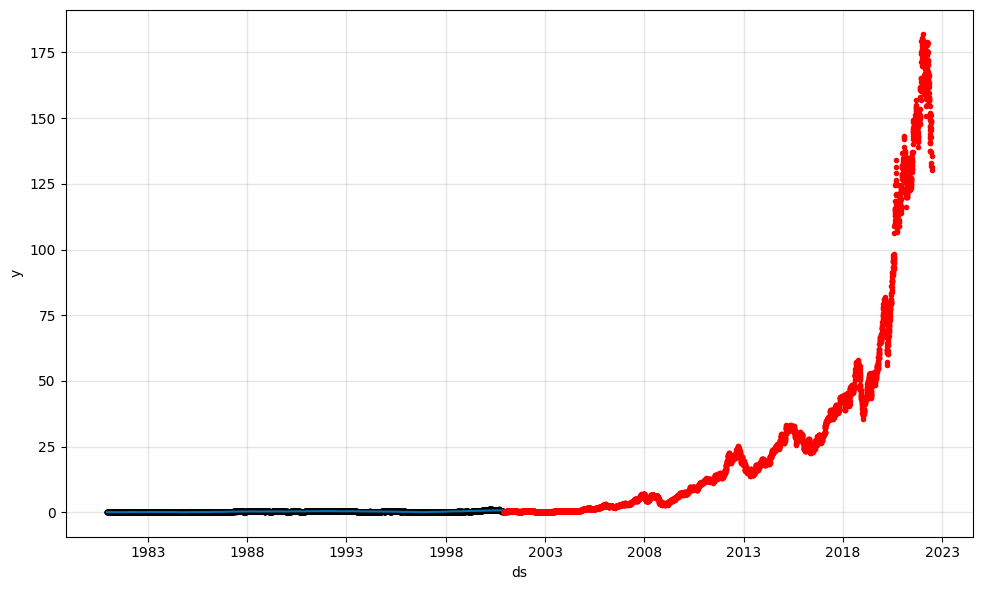

In [11]:
# Visualize the forecast
fig = m.plot(forecast)
ax = fig.gca()
ax.plot( df_test["ds"], df_test["y"], 'r.')

# Step 6: Time Series Decomposition

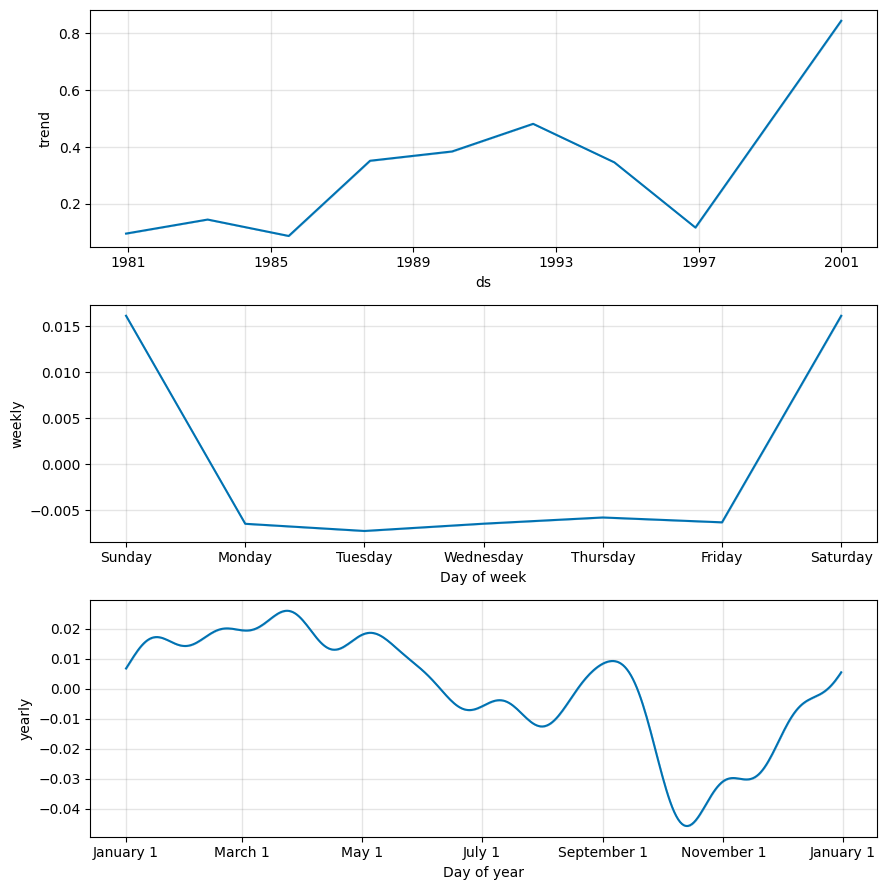

In [12]:
# Visualize the components
m.plot_components(forecast);

# Step 7: Identify Change Points

In [13]:
# Default change points
print(f'There are {len(m.changepoints)} change points. \nThe change points dates are \n{df.loc[df["ds"].isin(m.changepoints)]}')

There are 7 change points. 
The change points dates are 
      index         ds         y
577     577 1983-03-25  0.192522
1153   1153 1985-07-05  0.078683
1730   1730 1987-10-16  0.430804
2307   2307 1990-01-29  0.296875
2884   2884 1992-05-11  0.555804
3460   3460 1994-08-19  0.311384
4037   4037 1996-11-29  0.215402


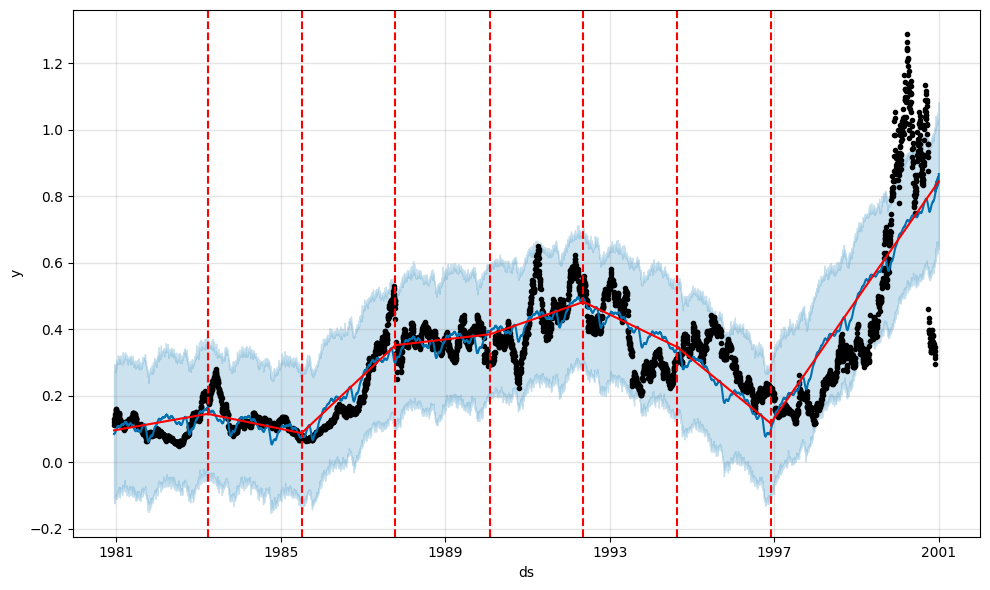

In [14]:
# Change points to plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# Step 8: Cross Validation

In [15]:
# Cross validation
df_cv = cross_validation(m, initial='1000 days', period='30 days', horizon = '60 days', parallel="processes")
df_cv.head()

INFO:prophet:Making 208 forecasts with cutoffs between 1983-10-01 00:00:00 and 2000-10-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7c08041a8b20>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl2zzi33h/drv000a4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl2zzi33h/fykq250b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl2zzi33h/qlpswu3_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl2zzi33h/0sp7387b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37132', 'data', 'file=/tmp/tmpl2zzi33h/drv000a4.json', 'init=/tmp/tmpl2zzi33h/0sp7387b.json', 'output', 'file=/tmp/tmpl2zzi33h/prophet_model5cfo8w74/prophet_model-20240724144755.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:CmdStan arg

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1983-10-03,0.140725,0.112792,0.168102,0.103237,1983-10-01
1,1983-10-04,0.141507,0.114469,0.172102,0.102121,1983-10-01
2,1983-10-05,0.142942,0.113518,0.171299,0.100446,1983-10-01
3,1983-10-06,0.144272,0.116185,0.172226,0.099330,1983-10-01
4,1983-10-07,0.145422,0.116651,0.174704,0.090960,1983-10-01


# Step 9: Prophet Model Performance Evaluation

Step 9 evaluates the cross-validation model performance.
* MSE (Mean Squared Error) sums up the squared difference between actual and prediction and is divided by the number of predictions.
* RMSE (Root Mean Square Error) takes the square root of MSE.
* MAE (Mean Absolute Error) sums up the absolute difference between actual and prediction and is divided by the number of predictions.
* MAPE (Mean Absolute Percentage Error) sums up the absolute percentage difference between actual and prediction and is divided by the number of predictions. MAPE is independent of the magnitude of data, so it can be used to compare different forecasts. But it's undefined when the actual value is zero.
* MDAPE (Median Absolute Percentage Error) is similar to MAPE. The difference is that it calculates the median instead of taking the average of the absolute percentage difference.
* SMAPE (Symmetric Mean Absolute Percentage Error) is similar to MAPE. The difference is that when calculating absolute percentage error, the denominator is the actual value for MAPE and the average of the actual and predicted value for SMAPE.

In [16]:
# Model performance metrics
df_p = performance_metrics(df_cv)
df_p.head()


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,0.015984,0.126427,0.081893,0.233166,0.189313,0.243550,0.658545
1,8 days,0.015788,0.125650,0.082322,0.236400,0.190440,0.246554,0.652783
2,9 days,0.015668,0.125173,0.082699,0.239651,0.193509,0.248830,0.656026
3,10 days,0.015907,0.126125,0.083549,0.243427,0.193566,0.252737,0.644248
4,11 days,0.016283,0.127606,0.084610,0.247113,0.198725,0.256201,0.629592


`plot_cross_validation_metric` method from Prophet helps us to plot the cross-validation performance results.

* The x-axis is the horizon. Because we set the horizon to be 30 days, the x-axis has a value up to 30.
* The y-axis is the metric we are interested in. We use `mape` as an example in this visualization.
* On each day, we can see three dots. This is because there are three models in the cross-validation, and each dot represents the MAPE from one model.
* The line is the aggregated performance across all the models. We can see that MAPE value increases with days, which is expected because time series tend to make better predictions for the near future than the far future.

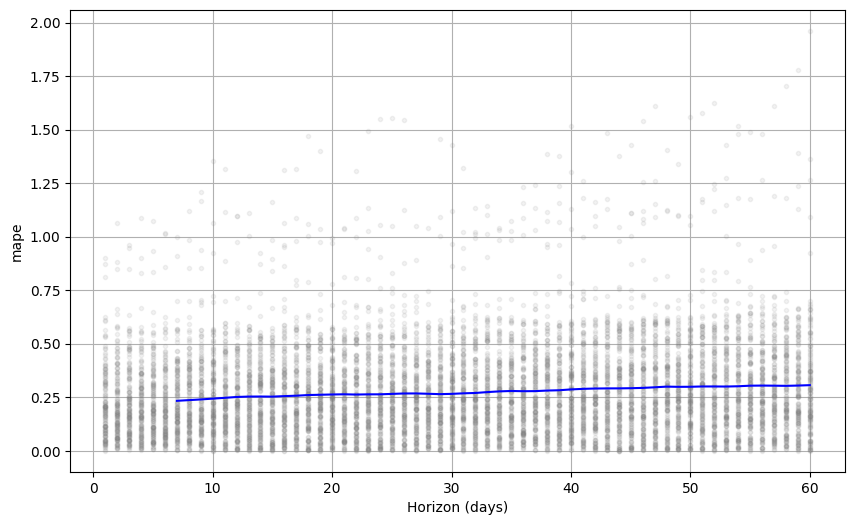

In [17]:
# Visualize the performance metrics
fig = plot_cross_validation_metric(df_cv, metric='mape')

# Step 10: Put All Code Together

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpixeepoby/b2nupgt9.json


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   10468 non-null  int64         
 1   ds      10468 non-null  datetime64[ns]
 2   y       10468 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 245.5 KB


DEBUG:cmdstanpy:input tempfile: /tmp/tmpixeepoby/dcwnjg2_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90805', 'data', 'file=/tmp/tmpixeepoby/b2nupgt9.json', 'init=/tmp/tmpixeepoby/dcwnjg2_.json', 'output', 'file=/tmp/tmpixeepoby/prophet_model_tutiaba/prophet_model-20240724074929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


There are 7 change points. 
The change points dates are 
      index         ds          y
1123   1123 1985-05-22   0.092076
2245   2245 1989-10-30   0.408482
3368   3368 1994-04-08   0.299107
4491   4491 1998-09-18   0.328125
5614   5614 2003-03-11   0.254107
6736   6736 2007-08-23   4.681071
7859   7859 2012-02-07  16.743929


INFO:prophet:Making 229 forecasts with cutoffs between 1982-05-17 00:00:00 and 2019-10-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7891bccf8190>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpixeepoby/pqlj8g3y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpixeepoby/hpc713ir.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpixeepoby/8oda8boo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpixeepoby/yskvjq9p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57213', 'data', 'file=/tmp/tmpixeepoby/hpc713ir.json', 'init=/tmp/tmpixeepoby/8oda8boo.json', 'output', 'file=/tmp/tmpixeepoby/prophet_model__n5pzlm/prophet_model-20240724074939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan arg

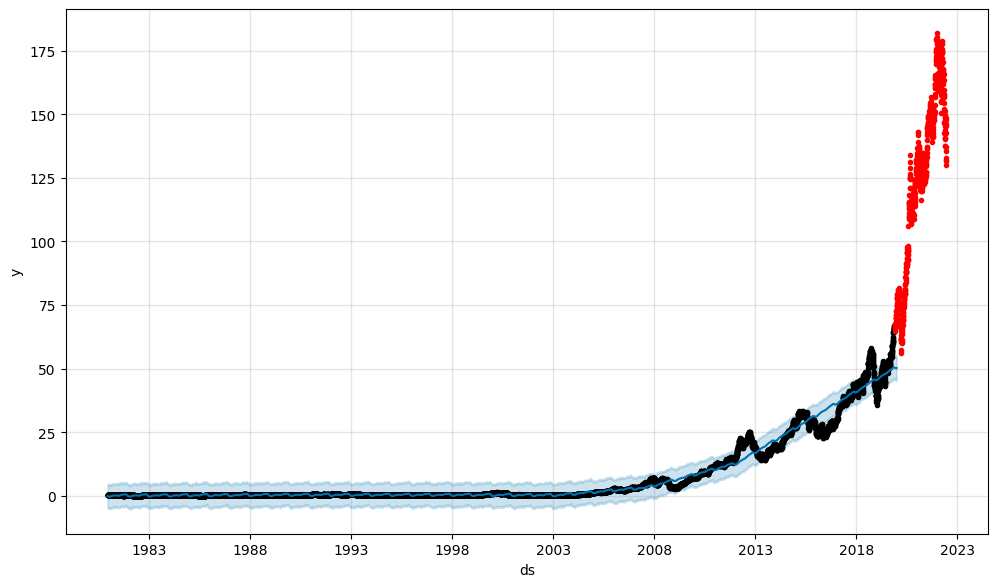

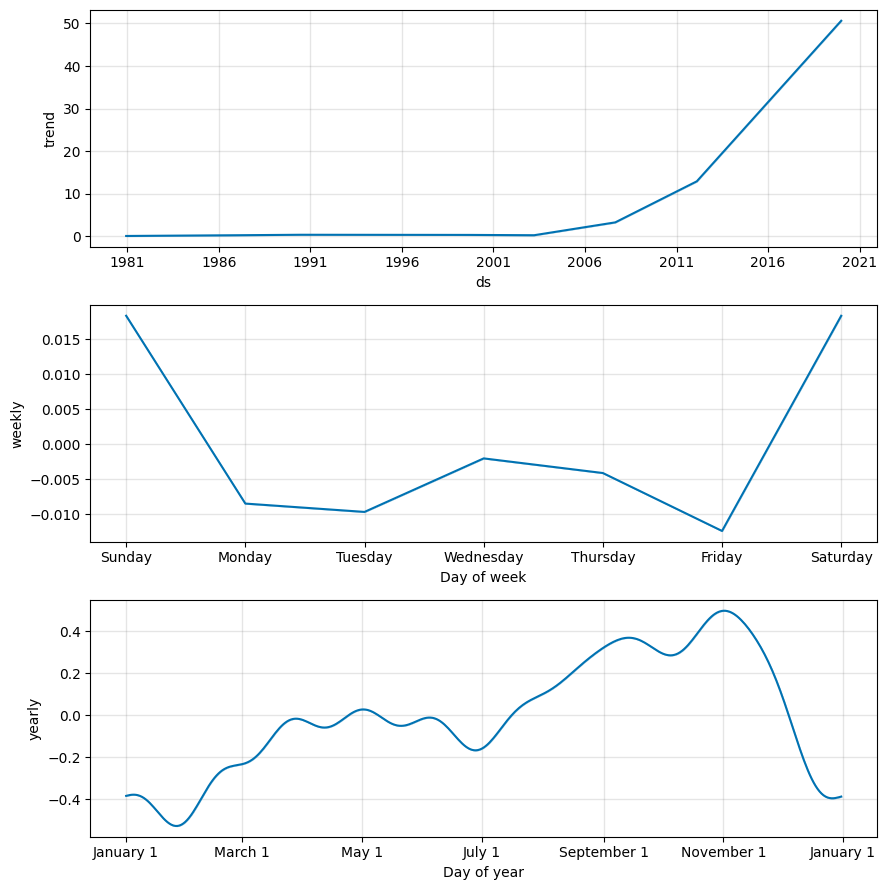

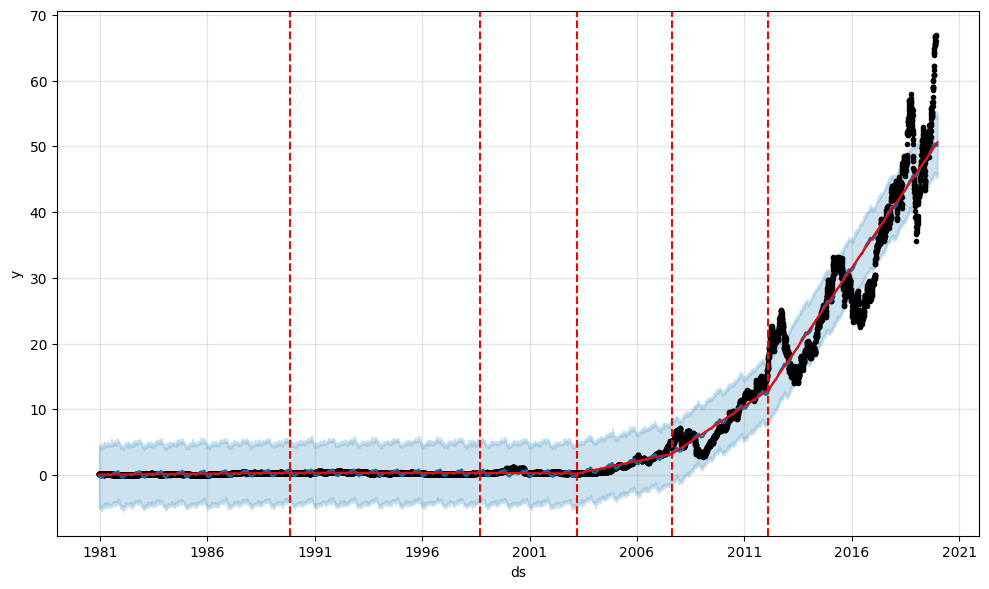

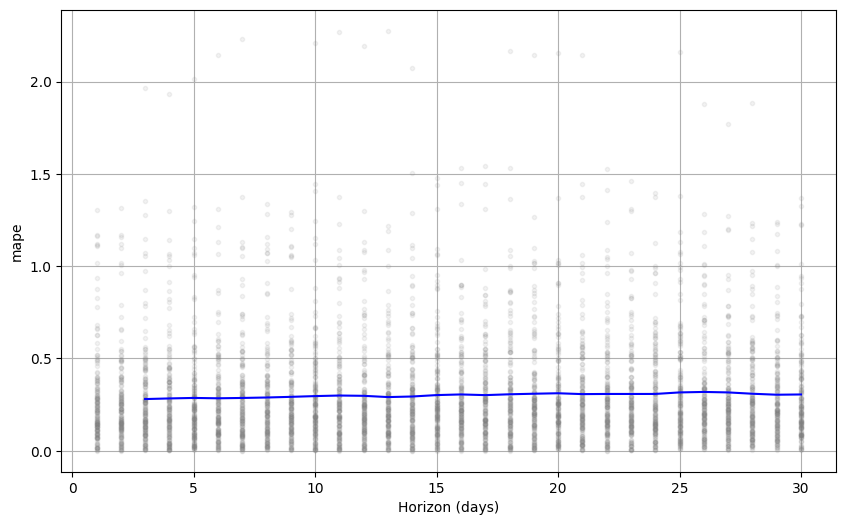

In [ ]:
###### Step 1: Install And Import Libraries

# Install libraries
!pip install yfinance prophet

# Data processing
import numpy as np
import pandas as pd

# Get time series data
import yfinance as yf

# Prophet model for time series forecast
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

# Visualization
import plotly.graph_objs as go


###### Step 2: Get Bitcoin Price Data

# Download Bitcoin data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_project/Dataset/1980-2021/AAPL.csv')

# Reset index and have date as a column
data.reset_index(inplace=True)

# Change date to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Take a look at the data
data.head()

# Declare a figure
fig = go.Figure()

# Candlestick chart
fig.add_trace(go.Candlestick(x=data.Date,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'],
                name = 'Bitcoin Data'))

# Keep only date and close price
df = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

# Rename date to ds and close price to y
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

# Take a look at the data
df.head()

# Data information
df.info()


###### Step 3: Train Test Split

# Train test split
df_train = df[df['ds']<='2019-11-30']
df_test = df[df['ds']>'2019-11-30']


###### Step 4: Train Time Series Model Using Prophet

# Create the prophet model with confidence internal of 95%
m = Prophet(interval_width=0.95, n_changepoints=7)

# Fit the model using the training dataset
m.fit(df_train)


###### Step 5: Use Prophet Model To Make Prediction

# Create a future dataframe for prediction
future = m.make_future_dataframe(periods=31)

# Forecast the future dataframe values
forecast = m.predict(future)

# Check the forecasted values and upper/lower bound
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# Visualize the forecast
fig = m.plot(forecast)
ax = fig.gca()
ax.plot( df_test["ds"], df_test["y"], 'r.')


###### Step 6: Time Series Decomposition

# Visualize the components
m.plot_components(forecast);


###### Step 7: Identify Change Points

# Default change points
print(f'There are {len(m.changepoints)} change points. \nThe change points dates are \n{df.loc[df["ds"].isin(m.changepoints)]}')

# Change points to plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


###### Step 8: Cross Validation

# Cross validation
df_cv = cross_validation(m, initial='500 days', period='60 days', horizon = '30 days', parallel="processes")
df_cv.head()


###### Step 9: Prophet Model Performance Evaluation

# Model performance metrics
df_p = performance_metrics(df_cv)
df_p.head()

# Visualize the performance metrics
fig = plot_cross_validation_metric(df_cv, metric='mape')


# Summary

In this tutorial, we talked about how to make time-series predictions of Bitcoin prices. The following topics are covered:
* How to train a time series forecasting model using Prophet?
* How to make predictions and do time series decomposition?
* How to identify changing points in the trend?
* How to do time series cross-validation?
* How to evaluate time series model performance using Prophet?

# Recommended Tutorials

- [GrabNGoInfo Machine Learning Tutorials Inventory](https://medium.com/grabngoinfo/grabngoinfo-machine-learning-tutorials-inventory-9b9d78ebdd67)
- [Hierarchical Topic Model for Airbnb Reviews](https://medium.com/p/hierarchical-topic-model-for-airbnb-reviews-f772eaa30434)
- [3 Ways for Multiple Time Series Forecasting Using Prophet in Python](https://medium.com/p/3-ways-for-multiple-time-series-forecasting-using-prophet-in-python-7a0709a117f9)
- [Time Series Anomaly Detection Using Prophet in Python](https://medium.com/grabngoinfo/time-series-anomaly-detection-using-prophet-in-python-877d2b7b14b4)
- [Time Series Causal Impact Analysis in Python](https://medium.com/grabngoinfo/time-series-causal-impact-analysis-in-python-63eacb1df5cc)
- [Hyperparameter Tuning For XGBoost](https://medium.com/p/hyperparameter-tuning-for-xgboost-91449869c57e)
- [Four Oversampling And Under-Sampling Methods For Imbalanced Classification Using Python](https://medium.com/p/four-oversampling-and-under-sampling-methods-for-imbalanced-classification-using-python-7304aedf9037)
- [Five Ways To Create Tables In Databricks](https://medium.com/grabngoinfo/five-ways-to-create-tables-in-databricks-cd3847cfc3aa)
- [Explainable S-Learner Uplift Model Using Python Package CausalML](https://medium.com/grabngoinfo/explainable-s-learner-uplift-model-using-python-package-causalml-a3c2bed3497c)
- [One-Class SVM For Anomaly Detection](https://medium.com/p/one-class-svm-for-anomaly-detection-6c97fdd6d8af)
- [Recommendation System: Item-Based Collaborative Filtering](https://medium.com/grabngoinfo/recommendation-system-item-based-collaborative-filtering-f5078504996a)
- [Hyperparameter Tuning for Time Series Causal Impact Analysis in Python](https://medium.com/grabngoinfo/hyperparameter-tuning-for-time-series-causal-impact-analysis-in-python-c8f7246c4d22)
- [Hyperparameter Tuning and Regularization for Time Series Model Using Prophet in Python](https://medium.com/grabngoinfo/hyperparameter-tuning-and-regularization-for-time-series-model-using-prophet-in-python-9791370a07dc)
- [Multivariate Time Series Forecasting with Seasonality and Holiday Effect Using Prophet in Python](https://medium.com/p/multivariate-time-series-forecasting-with-seasonality-and-holiday-effect-using-prophet-in-python-d5d4150eeb57)
- [LASSO (L1) Vs Ridge (L2) Vs Elastic Net Regularization For Classification Model](https://medium.com/towards-artificial-intelligence/lasso-l1-vs-ridge-l2-vs-elastic-net-regularization-for-classification-model-409c3d86f6e9)
- [S Learner Uplift Model for Individual Treatment Effect and Customer Segmentation in Python](https://medium.com/grabngoinfo/s-learner-uplift-model-for-individual-treatment-effect-and-customer-segmentation-in-python-9d410746e122)
- [How to Use R with Google Colab Notebook](https://medium.com/p/how-to-use-r-with-google-colab-notebook-610c3a2f0eab)

# Reference

* [Prophet documentation](https://facebook.github.io/prophet/docs/quick_start.html)
* [Prophet cross-validation and hyperparameter tuning](https://facebook.github.io/prophet/docs/diagnostics.html)
* [Prophet change point detection](https://facebook.github.io/prophet/docs/trend_changepoints.html)
